In [21]:
# General Imports
import re
from tqdm.notebook import tqdm
from emoji import demojize
from typing import Union, List

from nrclex import NRCLex

# Data Analysis and visualizations
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

# Import Spacy
import spacy
from spacy.lang.en import English
nlp = spacy.load("en_core_web_md", disable=["parser", "ner"])

# Import NLTK
import nltk
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download necessary NLTK data
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))
nltk.download('punkt', quiet=True)
nltk.download('sentiwordnet')
nltk.download('wordnet')

[nltk_data] Downloading package sentiwordnet to /home/jon/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
# Preprocessing functions

def preprocess_text(texts: Union[str, List[str], pd.Series], clean_emojis: bool = False) -> Union[str, List[str]]:
    cleaned_texts = []

    # Processing texts using Spacy pipeline
    for doc in tqdm(nlp.pipe(texts, batch_size=20), total=len(texts), desc="Cleaning Texts"):

        # Handle emojis: translate to text if not removing, else remove
        if clean_emojis:
            doc = re.sub(r':[^:]+:', '', demojize(doc.text))  # Remove emojis
        else:
            doc = demojize(doc.text)  # Convert emojis to text

        # Tokenization and preprocessing
        tokens = [token.text.lower() for token in nlp(doc) if token.text.isalpha()]

        # Removing stopwords and short tokens
        tokens = [token for token in tokens if token not in stop_words and len(token) > 1]

        cleaned_texts.append(' '.join(tokens))  # Rejoin tokens into a string

    return cleaned_texts


In [23]:
import os 
print(os.getcwd())
import sys
path = os.path.abspath(os.path.join('../../')) # or the path to your source code
sys.path.insert(0, path)
print(path)

/home/jon/Documents/HEC/HEC/Session 4 Winter 2024/Text Mining/Project/NLP-FakeNews-Detection/Emotion_Analysis
/home/jon/Documents/HEC/HEC/Session 4 Winter 2024/Text Mining/Project


In [24]:
#Load data 
#Path to Excel file
file_path = path + '/NLP-FakeNews-Detection/archive/truth_seeker.xlsx'

#Read Excel file
df = pd.read_excel(file_path)

In [25]:
# drop all the NaN values in the body column with an empty string
df = df.dropna(subset=['tweet'])

# Preview the loaded data 
display(df.head(10))


,Unnamed: 0,author,statement,target,BinaryNumTarget,manual_keywords,tweet,5_label_majority_answer,3_label_majority_answer,timestamp
0,0,D.L. Davis,End of eviction moratorium means millions of A...,1.0,1.0,"Americans, eviction moratorium",@POTUS Biden Blunders - 6 Month Update\n\nInfl...,Mostly Agree,Agree,Thu Sep 09 23:58:53 +0000 2021
1,1,D.L. Davis,End of eviction moratorium means millions of A...,1.0,1.0,"Americans, eviction moratorium",@S0SickRick @Stairmaster_ @6d6f636869 Not as m...,NO MAJORITY,Agree,Mon Aug 30 18:58:09 +0000 2021
2,2,D.L. Davis,End of eviction moratorium means millions of A...,1.0,1.0,"Americans, eviction moratorium",THE SUPREME COURT is siding with super rich pr...,Agree,Agree,Fri Aug 27 09:53:44 +0000 2021
3,3,D.L. Davis,End of eviction moratorium means millions of A...,1.0,1.0,"Americans, eviction moratorium",@POTUS Biden Blunders\n\nBroken campaign promi...,Mostly Agree,Agree,Tue Oct 05 20:37:14 +0000 2021
4,4,D.L. Davis,End of eviction moratorium means millions of A...,1.0,1.0,"Americans, eviction moratorium",@OhComfy I agree. The confluence of events rig...,Agree,Agree,Fri Aug 27 10:58:24 +0000 2021
5,5,D.L. Davis,End of eviction moratorium means millions of A...,1.0,1.0,"Americans, eviction moratorium","I've said this before, but it really is incred...",Agree,Agree,Fri Aug 27 14:00:41 +0000 2021
6,6,D.L. Davis,End of eviction moratorium means millions of A...,1.0,1.0,"Americans, eviction moratorium","As many face backlogged rent payments, America...",Mostly Agree,Agree,Sat Sep 18 01:50:18 +0000 2021
7,7,D.L. Davis,End of eviction moratorium means millions of A...,1.0,1.0,"Americans, eviction moratorium",@Thomas1774Paine @JoeBiden\n#DOJ@TheJusticeDep...,Mostly Agree,Agree,Tue Aug 10 05:28:26 +0000 2021
8,8,D.L. Davis,End of eviction moratorium means millions of A...,1.0,1.0,"Americans, eviction moratorium",@SocialismIsDone @TheeKHiveQueenB Its a win fo...,Agree,Agree,Tue Aug 24 01:11:52 +0000 2021
9,9,D.L. Davis,End of eviction moratorium means millions of A...,1.0,1.0,"Americans, eviction moratorium",@daysofarelives2 @Sen_JoeManchin There is not ...,NO MAJORITY,Agree,Wed Oct 06 05:41:01 +0000 2021


In [26]:

# Your text samples
texts = pd.DataFrame(df['tweet'], columns=['tweet'])

# Candidate labels
candidate_labels = ["happiness", "trust", "hope", "sadness", "anger", "fear"]

# Preprocess each title and track progress with tqdm
texts['processed_tweet'] = preprocess_text(texts['tweet'], clean_emojis=True)
# takes around 15 min


Cleaning Texts:   0%|          | 0/134197 [00:00<?, ?it/s]

In [27]:
display(texts.head(40))

,tweet,processed_tweet
0,@POTUS Biden Blunders - 6 Month Update\n\nInfl...,biden blunders month update inflation delta mi...
1,@S0SickRick @Stairmaster_ @6d6f636869 Not as m...,many people literally starving streets century...
2,THE SUPREME COURT is siding with super rich pr...,supreme court siding super rich property owner...
3,@POTUS Biden Blunders\n\nBroken campaign promi...,biden blunders broken campaign promises inflat...
4,@OhComfy I agree. The confluence of events rig...,agree confluence events right unprecedented af...
5,"I've said this before, but it really is incred...",said really incredibly way afghanistan complet...
6,"As many face backlogged rent payments, America...",many face backlogged rent payments americans o...
7,@Thomas1774Paine @JoeBiden\n#DOJ@TheJusticeDep...,instructing moratorium americans depend earnin...
8,@SocialismIsDone @TheeKHiveQueenB Its a win fo...,win americansim worried taking credit matter l...
9,@daysofarelives2 @Sen_JoeManchin There is not ...,never stimulus checks plan joey biden already ...


In [28]:
# Initialize an empty list to store the data
data_list = []

# Wrap the iteration with tqdm for a progress bar
for tweet in tqdm(texts['processed_tweet']):
    if pd.notnull(tweet):  # Check if the tweet is not null
        emotions = NRCLex(tweet)
        emotion_scores = emotions.raw_emotion_scores
        
        # Remove 'negative' and 'positive' from the scores if they exist
        emotion_scores.pop('negative', None)
        emotion_scores.pop('positive', None)
        
        # Sort the remaining emotions based on their frequency and pick the top two
        top_emotions = sorted(emotion_scores.items(), key=lambda x: x[1], reverse=True)[:2]
        
        # Check if we have at least two emotions to report
        if len(top_emotions) >= 2:
            # Append the data to the list with emotion names and scores
            data_list.append([
                tweet, 
                top_emotions[0][0], top_emotions[0][1],  # Emotion 1 and its score
                top_emotions[1][0], top_emotions[1][1]   # Emotion 2 and its score
            ])
        elif len(top_emotions) == 1:  # If only one emotion, fill the rest with NaN or placeholders
            data_list.append([
                tweet, 
                top_emotions[0][0], top_emotions[0][1],  
                None, 0  # No second emotion
            ])
        else:  # If no emotions, fill with NaN or placeholders
            data_list.append([
                tweet, 
                None, 0,  
                None, 0
            ])            


texts = pd.DataFrame(data_list, columns=['tweet', 
                                      'emotion 1', 
                                      'emotion 1 score', 
                                      'emotion 2', 
                                      'emotion 2 score'])

  0%|          | 0/134197 [00:00<?, ?it/s]

In [29]:
display(texts.head(50))

,tweet,emotion 1,emotion 1 score,emotion 2,emotion 2 score
0,biden blunders month update inflation delta mi...,fear,3,anger,2
1,many people literally starving streets century...,anger,3,disgust,3
2,supreme court siding super rich property owner...,fear,4,anger,3
3,biden blunders broken campaign promises inflat...,fear,6,anger,5
4,agree confluence events right unprecedented af...,disgust,3,fear,3
5,said really incredibly way afghanistan complet...,fear,2,anger,1
6,many face backlogged rent payments americans o...,anger,1,disgust,1
7,instructing moratorium americans depend earnin...,anticipation,1,trust,1
8,win americansim worried taking credit matter l...,sadness,2,trust,1
9,never stimulus checks plan joey biden already ...,sadness,2,anticipation,1


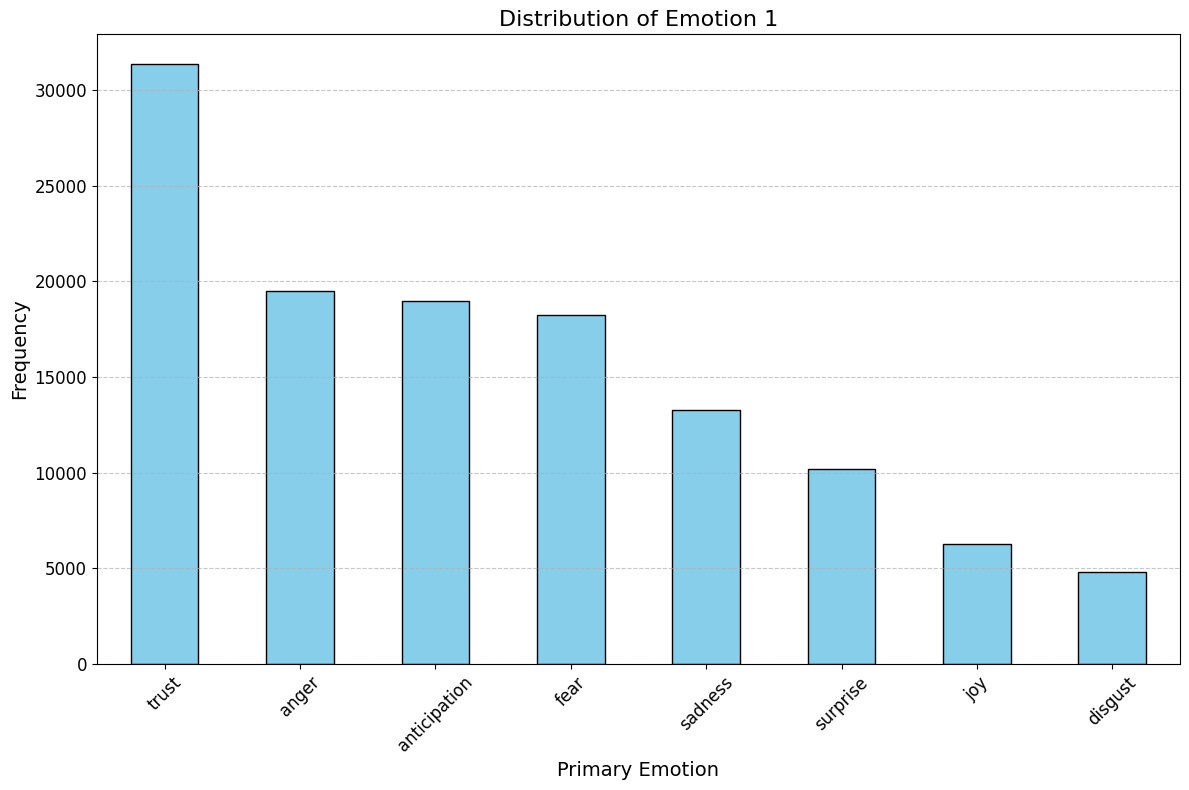

In [32]:

plt.figure(figsize=(12, 8))  # Increase figure size
texts['emotion 1'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Emotion 1', fontsize=16)
plt.xlabel('Primary Emotion', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, fontsize=12)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust the layout to make room for the rotated x-axis labels
plt.show()

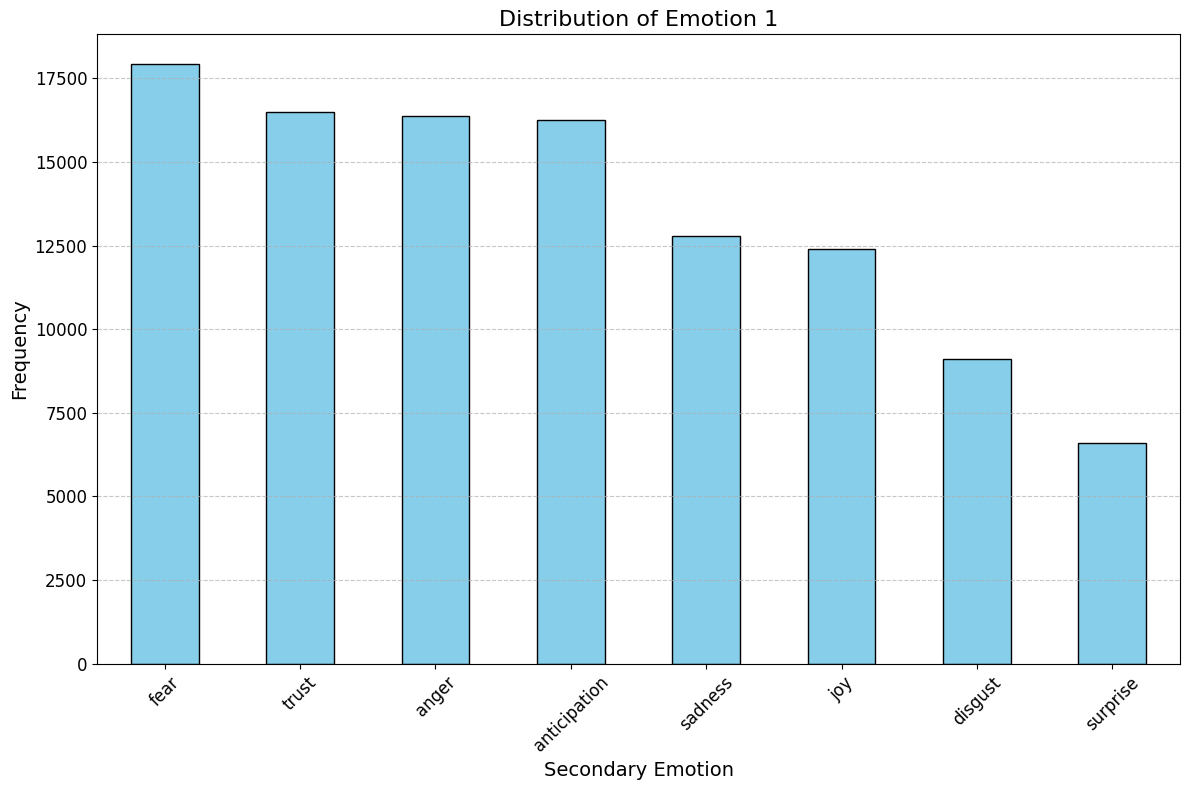

In [33]:

plt.figure(figsize=(12, 8))  # Increase figure size
texts['emotion 2'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Emotion 1', fontsize=16)
plt.xlabel('Secondary Emotion', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, fontsize=12)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust the layout to make room for the rotated x-axis labels
plt.show()